## Chapter 8 : Using Convolutions to Generalize

#### Convolutions in action
Convolution operations can be used to for solving the of translational variance limitation of fully connected networks because they provide two things
1. They provide a method of keeping the localised relationships betweem the pixels of an image. Just like a fully connected network.
2. They also can detect if the same localized realtionships occur in different parts of the image, without needing to relearn the relationship i.e `translational invariance`.

Now we will se some convolutions in action. The torch.nn module provides convolutions in -->
1. 1D: Time-Series
2. 2D: For images
3. 3D: For volumes or videos

For our CIFAR10 we will resort to nn.Conv2D, at minimum we will provide to the Conv2D function are
1. Number of input features(or channels since we are dealing with multichannel images i.e more that one value per pixel)
2. The number of output features.
3. The size of the kernel.
For instance in the first convolutional module we would have 3 input features per pixel (or channels) for our input image of RGB channels and an arbitrary number of channels in the output(lets day 16). The more channels in the output the more the capcity of the network and the network can learn more features. Also because we are randomly initializing, some of the features that we will get will be useless.

In [3]:
# imports
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import  transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F

In [3]:
# Lets define a Conv2D layer with 3 input channels and 16 output channels with a kernel size of 3x3.

conv = nn.Conv2d(3, 16, kernel_size = 3)  # if we give a kerne_size=3 it is the same as a 3x3 kernel
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

Now what should be the shape of the weight tensor. As our kernel_size = 3 so the weight would be a 3x3 for a single input channel. As the number of input channels is 3 the weight would be `in_ch*3*3`. An then the number of these individual `in_ch*3*3` weights is the number of output channels i.e `16*in_ch*3*3`. The bias would be a 16 valued vector that conforms to the number of output channels.

In [4]:
# lets test out the weight vector and the bias vectors
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

1. We can see how convolutional Networks are good for images, we have smaller models which look for local patterns whose weights are optimized for the whole image.
2. A 2D convolution produces a 2D image as an output whose pixels are the locally weighted sum pixels of the original image.
3. Because the weights are initialized randomly we will not see a meaningful output image.
4. As usual we need to add a zeroth batch dimension in the input data because pytorch expects a batch of images with `B x C x H x W` shaped tensor.


In [4]:
# lets get an image from the cifar 10 dataset

# download the cifar10 dataset from torchvision.datasets
cifar10 = datasets.CIFAR10("./datasets/CIFAR_10/", download = False, transform=transforms.ToTensor(), train = True)
cifar10_val = datasets.CIFAR10("./datasets/CIFAR_10/", download = False, transform = transforms.ToTensor(), train = False)

# stack the images to get the mean and the standard deviations of all channels
images = torch.stack([img for img,_ in cifar10], dim = 3)
image_reshape = images.view(3, -1) # We give the first dimension here and the rest are figured out according to the shape.
images_mean = image_reshape.mean(dim = 1)  # The dim=1 means that we are taking the mean along the first dimension i.e adding every column value
images_std = image_reshape.std(dim=1)

# get the tranformed cifar10 dataset with totensor() and normalize transformation applied
transformed_cifar10 = datasets.CIFAR10("./datasets/CIFAR_10/",
                                        download= False,
                                        train = True,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(images_mean, images_std)]))


transformed_cifar10_val = datasets.CIFAR10("./datasets/CIFAR_10/",
                                        download= False,
                                        train = False,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                    transforms.Normalize(images_mean, images_std)]))

# get only the classes of birds and planes
label_map = {0:0, 2:1}  # Birds are the zero class in  the dataset and 2 is the class number for planes.
class_names = ['airplanes', 'birds']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label == 0 or label == 2]
cifar_2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label == 0 or label == 2]

torch.Size([1, 3, 32, 32]) torch.Size([1, 16, 30, 30])


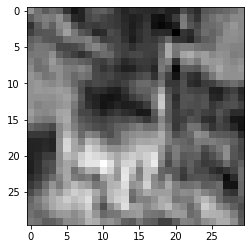

In [6]:
# Now lets get one image from the cifar2 dataset
import plotly.express as px
image, _ = cifar2[0]

# Now add a batch dimension and input it in the conv2d transformation
output = conv(image.unsqueeze(0))

# Check the size of the original and output image and plot the images
print(image.unsqueeze(0).shape, output.shape)

plt.imshow(output[0,0].detach(), cmap='gray')


Here we can see in the output shape that we have lost a few pixels, how did this happen:
1. This is the effect of doing the convolution operation at the boundary, applying the convolution kernel at the position 0,0 at the image means that there is no pixel at the left side of the kernel. We only have pixels at the right and the bottom of the image.
2. By default pytorch will slide the kernel at the position `width-kernel_width+1` horizontal and vertical positions. For odd sized kernels it results in images that are (one/half) smaller of the kernel size(3/2=1). This explains the missing two pixels in each side.
3. However pytorch gives us the utility of padding the image with ghost pixels (which has 0 value) around the border that have a zero output value as far as convolution operation is concerned. In our case specifying the padding as 1 means that our kernel has one extra pixel to compute the output on the left side corner of the image. The net result is that the output now has the same size as the input.
4. For even sized kernels we would have to pad with different numbers on all 4 sides. Pytorch does not offer this functionality in the convolution operation itself, but we have this funcitonality in `torch.nn.functional.pad`, it is best to stay with odd-sized kernels. Even sized kernels are just odd.

torch.Size([1, 16, 32, 32]) torch.Size([3, 32, 32])


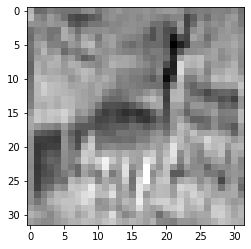

In [7]:
# Now would see the same operation with padding
conv = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)

output = conv(image.unsqueeze(0))
print(output.shape, image.shape)

plt.imshow(output[0][0].detach(), cmap='gray')

##### Detecting features with convolutions
We know that weights and biases are parameters that are learned through backpropagation. But we can play around and set our own weights and biases and see what happens.

torch.Size([1, 16, 32, 32])


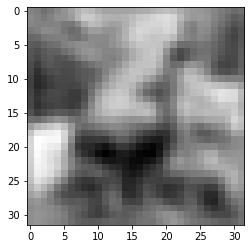

In [8]:
# lets start by making the bias as zero and removing an unescessary factor.
with torch.no_grad():
    conv.bias.zero_()

# Now lets set the weigths by initializing to a value.
with torch.no_grad():
    conv.weight.fill_(1.0/9.0)

# we could have gone with conv.one_() which would have resulted in the output pixel value to be sum of all the neighbouring values.

# Now lets see the effect this has on our convolution output image
output = conv(image.unsqueeze(0))

print(output.shape)
plt.imshow(output[0,0].detach(), cmap='gray')

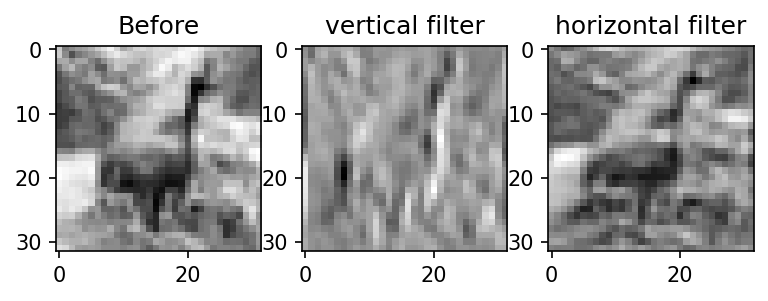

In [9]:
# Now lets try anothe new kernel
conv = nn.Conv2d(3,1, kernel_size=3, padding = 1)

with torch.no_grad():
    conv.weight[:] =  torch.tensor([[-1.0, 0.0, 1.0],
                                    [-1.0, 0.0, 1.0],
                                    [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

output_vertical = conv(image.unsqueeze(0))

with torch.no_grad():
    conv.weight[:] =  torch.tensor([[-1.0, -1.0, 1.0],
                                    [0.0, 0.0, 0.0],
                                    [1.0, 1.0, 1.0]])
    conv.bias.zero_()
output_horizontal = conv(image.unsqueeze(0))

# plot the images
fig, (ax1,ax2,ax3) = plt.subplots(nrows = 1,ncols = 3, sharey = False)
ax3.imshow(output_horizontal[0,0].detach(), cmap = 'gray')
ax3.set_title('horizontal filter')
ax2.imshow(output_vertical[0,0].detach(), cmap='gray')
ax2.set_title('vertical filter')
ax1.imshow(image[0], cmap = 'gray')
ax1.set_title('Before')
fig.set_dpi(150)

We can see that by using the above kernel weights we only can make out vertical lines, similarly we have also created a filter which can sperate all the horizontal lines. By generating and applying these types of filters we can manually detect features in our image and the job of a computer vision reasercher has been to research a combination of these filters so that the features are highlighted and objects are recognized.
##### But where does deep learning come into the picture in identifying kernels.
The deep learning algorithm estimates these kernel weights in the manner which is the most effective(make the loss least). For e.g the successive filters from the filterbank that are applied to an image, the neural network estimates the kernel weights of the filters and the different channels of the output image correspond to the different features(one channel for horizontal, vertical edges and diagonal edges, etc.)

#### Looking further with Depth and Pooling
We have achieved locality and translation invariance. We are using kernels which are 3x3 and 5x5, this takes care of the locality but the problem is what about the big picture. How do we know that all the objects in our picture are 3x3 or 5x5 pixels wide, we don't know because they do. This is something we will need to look into if we want to solve our problem since our images are small the objects have a span of several pixels across. There are two solutions for this problem:
1. Using a bigger kernel the max limit for a convolutional kernel for a 32x32 image is 32x32, but using this kernel we would be like making the covolution oepration the same as the fully connected network with the same problems.
2. The second option here is to stack one convolution after another and at the same time downsampling the image between successive convolutions.

#### From large to small: Downsampling
Downsampling could occur in multiple different ways. Scaling the image in half is equivalent to taking the four neighbouring pixels as an input and producing one pixel as the output. How we compute the values of the output is upto us. We could:
1. Take the average of the neighbouring pixels to cumpute the output pixel. This is called as `Average Pooling`.
2. Take the maximum of the four pixels. This approach is called as `Max Pooling` and the downside of this is that it discards 3/4 of the data.
3. Perform a strided convolution where every nth pixel is calculated. A 3x4 convolution with a stride of 2 still incorporates the inputs of all pixels from the previous layer. It is a good approach but it still has not surpassed max pooling.
We will focus on maxpooling. Intuitively what is happening here is that after the convolution operation the outputs are passed through the activation function which further highlights the features captured by the kernels in the image. Then what happens is that we keep the maximum of those 2x2 pixel values and ensure that the feature which was highlighted the most survives the downsampling step at the expense of other steps.\
Max pooling is provided by nn.Maxpool2d().It takes the input size of the neighbourhood on which to operate the pooling operation. If we wish to downsample our image by half we should use a size of 2.

In [10]:
# Lets see Maxpool2d in action
maxpool = nn.MaxPool2d(kernel_size=2)
output = maxpool(image.unsqueeze(0))
print(image.shape, output.shape)

torch.Size([3, 32, 32]) torch.Size([1, 3, 16, 16])


So what happens when we combine these two features is that, the first set of kernels which operates on a 8x8 image captures small features like edges, vertical lines etc, and then the maxpooling happens which downsamples the image so that now only the highlighted features of the image are in focus. The as we are using the same kernel size but the size of the image has been reduced the next kernel now captures more high level features of the image which are a combination of the previous features. `This combination allows the convolution network to see very complex scenes and can be used in a wide variety of tasks like time-series forecasting, NLP etc and not only in Image recognition and it can also figure out much compelx images than a 32x32 cifar10 image.`

##### Putting it altogether for our Network
Now that we have the building blocks we can put these building blocks to use and make our network which can classify the images of the birds and the planes. We will make a model that has both the convolution operation and the linear layers because the convolution operation outputs the image as multi channel 2D image but to give the input for the log-likelihood loss function as plane or a bird we need the output to be a 1D vector of probabilites.\
So now we need to take this multi-channel image and convert it to a 1D vector of probabilities for it to be input to the log-likelihood loss function and complete our network with a set of fully-connected layers.

In [11]:
from typing import OrderedDict


model = nn.Sequential(OrderedDict([
    ('conv2d_1',nn.Conv2d(3, 16, kernel_size=3, padding=1)),
    ('Activation_1', nn.Tanh()),
    ("maxpooling2d_1", nn.MaxPool2d(2)),
    ('conv2d_2', nn.Conv2d(16,8, kernel_size = 3, padding = 1)),
    ('Activation_2', nn.Tanh()),
    ('Maxpooling2d_2', nn.MaxPool2d(2)),
    # This model also has one layer here which convert the 2D image with multiple channels to a 1D vector required by the linear layer
    ("linear Layer_1", nn.Linear(8*8*8, 32)),
    ("Activation_3", nn.Tanh()),
    ("Output_layer", nn.Linear(32,2))
]))

We can see that the size of the first linear layer is dependent upon the output of the Maxpool2d layer i.e `8*8*8 = 512`.

In [12]:
# lets check the number of parameters in the mode
parameters = [p.numel() for p in model.parameters()]
print(sum(parameters), parameters)

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]


The number of parameters of the model is 18090 which is very reasonable for such small dataset of 32x32 images. In order to increase the capacity of the model we would increase the number of output channels of the convolutional layers, which would increase the linear layer size as well.
`We put the warning text, for a reason. This model has zero chance of running`

In [13]:
# These two lines were used to run the model defined above but the model will not run because it is missing some parts which is explained below.
# output = model(image.unsqueeze(0))
# output

What is missing here is the conversion of the `8*8*8` image into a 512 element 1D vector. This could be achieved by calling view on the last nn.Maxpool2D, but unfortunately we do not have explicit visibilty of the output of each module when we use nn.Sequential.

#### Subclassing the nn.module
Sometimes when building a Neural Network we stumble across a problem where we want to compute something that the premade modules do not cover. Here it is a very simple thing  like reshaping, but further along we would like to implement residual connections. So in this section we would build our own nn.Module subclass so that we can use them like the prebuilt ones with added functionality or in nn.Sequential.
1. When we want to build models that do many other things other than only applying many layers one after another, we need to leave nn.Sequential for something that gives us additional stability. Pytorch allows us to use any computation in our model by subcalssing the nn.Module.
2. In order to subclass the nn.module we need to define both the forward pass of the network which takes in the inputs and return the outputs, and typically we need to define the backward pass also but if we use the standard pytorch operation we do not need to define the backwards function. Pytorch takes care of the backward pass.
3. Typically our defined computation would make use of other premade modules like the convolution or other modules. To use these submodules we typically define them in the constructor `__init__` and assign them to self for use in the forward function. Remember you need to call `super().__init__()` before you can do that(you need to import the constructor of the nn.Submodule use its predefined functionality and add your own to it. Super takes care of importing of all the functionality of the base class and you can just add the enhancement and get it working)\
`Note : ommiting the flatten layer was a design choice. Recently pytorch gained the nn.flatter layer(version 1.3)`

In [14]:
# Our network as an nn.Module
# To do this we define all the layers we defined in our model in the constructor and then use their instances one after another in forward

class Net(nn.Module):
    def __init__(self):
        # define the layers of your custom model in the constructor
        super().__init__()  # Makes all the other methods of nn.Module avaible for use
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
        self.act1 = nn.Tanh()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size = 3, padding = 1)
        self.act2 = nn.Tanh()
        self.maxpool2 = nn.MaxPool2d(2)
        self.linear1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.output = nn.Linear(32,2)
    
    def forward(self, x):
        out = self.maxpool1(self.act1(self.conv1(x)))
        out = self.maxpool2(self.act2(self.conv2(x)))
        out = out.view(-1, 8*8*8)  # This is the reshaping step that we were missing earlier. reshape into a row vecotr with shape (1,8*8*8)
        out = self.act3(self.linerar1(out))
        out = self.linear2(out)
        return out

The Net model is equivalent to our model that we defined earlier in our nn.Sequential class with the adden flatten step(which was not provided in the Sequential model) but here we can manipulate the output of maxpool2 directly and can call the out.view() method on the tensor to change its shape into a BxN vector so that it can be inputted to the first fully connected layer. We leave the batch dimension as -1 because we do not know the size of the batch.\
Recall that the goal of the classification network is to typically compress information in the sense that we start with a sizable number of pixels and we reach an output vector of probabilites. Our goal is reflected in the design of the architecture.
1. It is done by reducing the number of channels in the convolution operation.
2. It is done by reducing the size of the pixels in the pooling operation.
3. It is done by reducing the number of hidden neurons in the fully connected layers.\
This is being done to compress the information and make predictions on only the most important information in the whole image, and this is a common trait of classification networks, but in some other architectures only the resolution is reduces while increasing the number of channels(still resulting in a reduction in size). It seems that the pattern of fast information reduction works well with shallow networks and smaller images but is not suitable for deeper networks, but the first layer is exceptional in such a way that it greatly increases the overall dimension.

##### How pytorch keeps track of parametes of user defined submodules.
Interestingly in pytroch, `assigning an instance of the nn.Module(the linear and conv layers) to the attribute of nn.Module automatically registers the module as submodule`.\
`Note : The attributes of the nn.Module should be a top-level attribute, not a list or a dict of submodule instances, otherwise the optimizer will not be able to locate the paramters of the instances. For instances where your model needs a list/dict of submodules, pytorch provides nn.ModuleList and nn.ModuleDict classes`.\
We can define and call some arbitrary methods of nn.Module subclass. For eg. if the model has a different functionality when predciting then it will make sense to define a predict method and use that to predict. But doing so is like calling the forward method instead of the calling the module as a function by the call method(it runs without intiating the accessory methods such as hooks and the JIt does not check the model structure because we do not have `__call__`).\
This allows the Net to have access to the parameters of its submodules without further action by the user.

In [16]:
# lets define the model
model = Net()

# lets get the parameters to check of our subclass model if we have the same number of parameters
paramters = [p.numel() for p in model.parameters()]
print(sum(paramters), parameters)

18090 [432, 16, 1152, 8, 16384, 32, 64, 2]


We can see by comparing both the models that the number of parameters is the same (which means that pytorch is discovering the parameters of all the layers) as the previous model that we defined(because we just added a flatten layer which just reshapes the tensor we did not introduce any extra parameters)

So what is happening is here is that we call the parameters on the instance of the Net() class, it recursively calls the parameters() on all the instances of the submodules defined as attributes of the net class(no matter how nested), and in the same way for all the submodules the grad attribute (which has been populated by autograd) is also found and updated to minimize the loss.

`By now we know the utility of creating our own subclass of the nn.Module and looking into the constructor of the subclass we can see that we have defined submodules as attributes so that their parameters can be accessed by pytorch at runtime, but we are also defining those submodules which do not have parameters of their own like nn.Tanh() and nn.Maxpool2d(). It would be good if instead of defining the submodules in constructor we could just call them in the forward method just as we called the view() method.`

##### The functional API: 
The solution to the problem defined above is the pytorch `Functional API`. Every nn.Module has its functional counterpart, and by functional we mean `having no internal state (whose output is solely determined by the value of it's inputs)`. Indeed `torch.nn.functinal` provides many functions that work like modules we find in nn. But instead of working on inputs and parameters stored like the module counterparts they accept inputs and paramters as arguments to the function call. For instance `nn.Linear` has `nn.functional.linear` which has a function signature as `linear(inputs, weight, bias = None)` which indicates that it accepts the inputs and weights and biases as arguments

Back to the model it seems to make sense to define the conv2d and linear layers as modules because pytorch can keep track of parameters on its own, however we can safely switch to functional counterparts for  pooling and activations since they have no parameters.

In [11]:
# lets define our new model using the mix of fucntional api and the subclassing module

import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # tanh will be defined by the functional API in forward
        # maxpool will be defined by the functional API in the forward method
        self.conv2 = nn.Conv2d(16,8, kernel_size = 3, padding = 1)
        # tanh will be defined by the functional API in forward
        # maxpool will be defined by the functional API in the forward method
        self.fc1  = nn.Linear(8*8*8, 32)
        # tanh will be defined by the functional API in forward
        self.fc2 = nn.Linear(32,2)
    
    def forward(self, x):
        """ Here we would define the steps of the computation and also the tanh and maxpool layers. x is the input"""

        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

This is way more concise than the full definition of the class. But if the layer requires more arguments then it would be best to define it in the constructor. Thus the functional module also sheds light on what the nn.Module API is all about. A module is a container for state in the forms of parameters and submodules combined with the instructions to do a forward.\
Using either of the functional API's or modular API's is a matter of prefernce according to the situation.

In [20]:
# lets check if out model run 
model = Net()
image, _  = cifar2[88]
output = model(image.unsqueeze(0))
print(output)

tensor([[-0.2459, -0.0383]], grad_fn=<AddmmBackward0>)


We got two numbers. Then we are certain that the information flows correctly and we have got the correct number of outputs. We might realize it right now but in more complex models the getting the size of the first linear layer is sometimes a source of frustration, even famous practitioners rely on putting arbitrary values and backtracking from the output to get to the correct input shapes. 

#### Training our Convnet
We are not a point where we can train our convnet and see the results that it produces as compared to our linear classifier. The training loop stays the same as our linear classifier with the addition of accuracy in the mix to monitor the performance of our model.

Recall that the core of our convnet has two loop, one for epochs and another for the dataloader for going over the batches. Now lets define our loop.

In [8]:
# import datetime for monitoring time
import datetime

# Instantiate the model
convnet = Net()

# Initlaize the dataloader
train_dataloader = torch.utils.data.DataLoader(cifar2, batch_size= 32, shuffle = False)
val_dataloader = torch.utils.data.DataLoader(cifar_2_val, batch_size = 32, shuffle = False)

# Intialize loss function
cross_ent_loss_fn = nn.CrossEntropyLoss()

# Initlaize the optimizer
optimizer_sgd = optim.SGD(convnet.parameters(), lr = 1e-2)

# define the training loop
def training_loop(n_epochs, model, optimizer, loss_fn, train_data, val_data):
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0  # Initialize the loss for each epoch
        loss_val = 0.0
        for image, label in train_data:
            # carry out the forward pass
            # This does not require us to reshape the image with batch_size because the train_loader already give batches.
            pred = model(image)

            # compute the training loss per batch
            loss = loss_fn(pred, label)

            # compute the validation loss and the accuracy
            # with torch.no_grad():
            #     for val_image, val_label in val_data:
            #         val_pred = model(val_image)
            #         val_loss = loss_fn(val_pred, val_label)
            #          # This transforms the val_loss from a tensor to a python number which is nescessary to escape gradients.
            #         loss_val += val_loss.item()

            # zero out the gradients of the optimizer
            optimizer.zero_grad()
            # carry out backward pass
            loss.backward()
            # carry out the optimizer step
            optimizer.step()

            # This transforms the loss from a tensor to a python number which is nescessary to escape gradients
            loss_train += loss.item() 

        # print the training loss, validation loss, accuracy per epoch
        if epoch == 1 or epoch %20 == 0:
            print(f"{datetime.datetime.now()} --> Epoch : {epoch} | Train Loss : {loss_train/len(train_data)}")


# Run the training loop
training_loop(n_epochs = 200,
             model = convnet,
             optimizer = optimizer_sgd, 
             loss_fn=cross_ent_loss_fn, 
             train_data= train_dataloader, 
             val_data=val_dataloader)

2022-10-10 16:28:43.519214 --> Epoch : 1 | Train Loss : 0.5349392931872663
2022-10-10 16:29:48.247175 --> Epoch : 20 | Train Loss : 0.25915760461229104
2022-10-10 16:31:00.092121 --> Epoch : 40 | Train Loss : 0.19767980106151142
2022-10-10 16:32:11.808920 --> Epoch : 60 | Train Loss : 0.14398290847722714
2022-10-10 16:33:23.212315 --> Epoch : 80 | Train Loss : 0.09548568038549572
2022-10-10 16:34:34.248517 --> Epoch : 100 | Train Loss : 0.058353324399921844
2022-10-10 16:35:45.325411 --> Epoch : 120 | Train Loss : 0.03499921111571498
2022-10-10 16:36:56.069209 --> Epoch : 140 | Train Loss : 0.022086896718637394
2022-10-10 16:38:07.206457 --> Epoch : 160 | Train Loss : 0.01486979045432073
2022-10-10 16:39:18.780834 --> Epoch : 180 | Train Loss : 0.010584756161440343
2022-10-10 16:40:29.568234 --> Epoch : 200 | Train Loss : 0.007932323896989654


`Now we can see from the above output that the network has been trained to a very low loss, but that nescessarily does not mean that the accuracy of the network on unseen images is high also.`\
So we could find out the accuracy of our model by running the model against the training and the validation sets and see the accuracy.

In [9]:
def validate(model, train_data, val_data):
    for name, loader in [("train",train_data), ('validation', val_data)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for image, label in loader:
                pred = model(image)

                _, predicted = torch.max(pred, dim=1)
                total += label.shape[0]
                correct += int((predicted==label).sum())

        print(f"{name} Accuracy : {correct/total}")

validate(convnet, train_data= train_dataloader, val_data = val_dataloader)

train Accuracy : 0.9992
validation Accuracy : 0.8955


Thats quite better than our linear model which could only achieve an accuracy of around 81% on the validation set. This achieves better performance with lesser number of parameters. Lets run it for a few more epochs and see what performance we could squeeze out.\
Model trained till 100 epochs --> 88.15 % val accuracy and 96.03 % train accuracy\
Model trained till 200 epochs --> 89.55 % val accuracy and 99.92% train accuracy\
Anlyzing the above sentences we can see that the model trained on 200 epochs has overfitted the data and could not generalize better even though it's loss is very low.

#### Saving and loading our model
Since we are satisfied with our progress we can save our model, so that we can load the weights for inference without having to train the model again. This is very useful if we have a very large model which takes a long time to train.
But pytorch only save the weights of the model and not the model structure.

In [16]:
path = "./saved_models/"
torch.save(convnet.state_dict(), path+"birds_vs_airplanes.pt")

Pytorch just saves the weights of the convnet. If we want to use the model again we would need to define the model architecture, instantiate a convnet object and load the weights into the model.

In [17]:
# Lets load the saved model
loaded_model = Net()
loaded_model.load_state_dict(torch.load(path+"birds_vs_airplanes.pt"))

<All keys matched successfully>

The all keys matched succesfully message shows that our model has been loaded successfully.

### Training the model on the GPU
We have trained the model and saved it the memory, now whenever we want to use our model we can just use the saved weights to perform inference.
1. Training on the GPU makes the model training faster. We can use the .to() method to move our tensors of the dataloader to the GPU, after which the computation will automatically take place. But we also need to move our parameters() tensor to the GPU. The nn.Module impelements a .to() function which transfers its parameters to the GPU.
2. There is subtle difference between `nn.module.to()` and `tensor.to()` methods. The module.to() method modifies the module instance inplace, but the tensor.to() returns a new tensor. 
3. `One good practice is to create the optimizer after moving the parameter tensors to the appropriate device.`
4. `It is good practice to use a GPU if one is available. A good pattern is to use a GPU or CPU depending upon torch.cuda.is_available()`

In [5]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}")

Training on device cuda


Then we can update our code with the line which transfer the dataloader to the GPU using the tensor.to() method. It is a very small change, just two lines of code. We would also need to move our model instance to the GPU also and 

In [12]:
# import datetime for monitoring time
import datetime

# One important thing to realize is to instantiate the optimizer and the model afterdefining the training loop and moving the data to the tensor

# define the training loop
def training_loop(n_epochs, model, optimizer, loss_fn, train_data, val_data):
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0  # Initialize the loss for each epoch
        loss_val = 0.0
        for image, label in train_data:
            # Move the images and labels to the GPU. This is the only step which makes the model train on the GPU. 
            image = image.to(device=device)
            label = label.to(device = device)


            # carry out the forward pass
            # This does not require us to reshape the image with batch_size because the train_loader already give batches.
            pred = model(image)

            # compute the training loss per batch
            loss = loss_fn(pred, label)

            # zero out the gradients of the optimizer
            optimizer.zero_grad()
            # carry out backward pass
            loss.backward()
            # carry out the optimizer step
            optimizer.step()

            # This transforms the loss from a tensor to a python number which is nescessary to escape gradients
            loss_train += loss.item() 
        # compute the validation loss and the accuracy
        with torch.no_grad():
            for val_image, val_label in val_data:
                # move the tensors of the loader to the GPU.
                # This step was added after we trained once on the GPU without the validation step with a training time of 3m.
                val_image = val_image.to(device = device)
                val_label = val_label.to(device = device)
                val_pred = model(val_image)
                val_loss = loss_fn(val_pred, val_label)
                # This transforms the val_loss from a tensor to a python number which is nescessary to escape gradients.
                loss_val += val_loss.item()
        # print the training loss, validation loss, accuracy per epoch
        if epoch == 1 or epoch %20 == 0:
            print(f"{datetime.datetime.now()} --> Epoch : {epoch} | Train Loss : {loss_train/len(train_data)} | Val Loss : {loss_val/len(val_data)}")


# This step of defining the model and optimizer after the data_loader has been moved to the GPU is only applicable when using a GPU
# Instantiate the model
convnet = Net().to(device=device)  # The .to(device = 'cuda') move the model to the GPU.

# Initlaize the dataloader
train_dataloader = torch.utils.data.DataLoader(cifar2, batch_size= 32, shuffle = False)
val_dataloader = torch.utils.data.DataLoader(cifar_2_val, batch_size = 32, shuffle = True)

# Intialize loss function
cross_ent_loss_fn = nn.CrossEntropyLoss()

# Initlaize the optimizer
optimizer_sgd = optim.SGD(convnet.parameters(), lr = 1e-2)


# Run the training loop
training_loop(n_epochs = 100,
             model = convnet,
             optimizer = optimizer_sgd, 
             loss_fn=cross_ent_loss_fn, 
             train_data= train_dataloader, 
             val_data=val_dataloader)

2022-10-12 07:06:45.962364 --> Epoch : 1 | Train Loss : 0.537982549911109 | Val Loss : 0.46123253494974165
2022-10-12 07:07:07.496024 --> Epoch : 20 | Train Loss : 0.26882070379135325 | Val Loss : 0.2892750169313143
2022-10-12 07:07:29.329909 --> Epoch : 40 | Train Loss : 0.2077372375601968 | Val Loss : 0.2704237648655498
2022-10-12 07:07:50.313408 --> Epoch : 60 | Train Loss : 0.15647608473801766 | Val Loss : 0.27687373851972913
2022-10-12 07:08:11.531732 --> Epoch : 80 | Train Loss : 0.10731856414554314 | Val Loss : 0.3035459849569533
2022-10-12 07:08:32.837458 --> Epoch : 100 | Train Loss : 0.0660671279661524 | Val Loss : 0.336388751036591


We can see that the training on the GPU took around 3 min(without the validation step) while training the same thing on the CPU took around 12 min(without the validation step). This difference might not be very significant because we have a very small dataset, but it is very significant when we have a larger model and a larger dataset.

The training with the validation set for 100 epochs was done in 3 min on the GPU. This shows how much a GPU is faster.

In [13]:
# lets check the training and the validation accuracy of the model by performing the computations on the GPU
def validate(model, train_data, val_data):
    for name, loader in [("train",train_data), ('validation', val_data)]:
        correct = 0.0
        total = 0.0

        with torch.no_grad():
            for image, label in loader:
                image = image.to(device=device)
                label = label.to(device=device)
                pred = model(image)

                _, predicted = torch.max(pred, dim=1)
                # predicted = predicted.to(device=device)
                total += label.shape[0]
                correct += (predicted==label).sum().item()

        print(f"{name} Accuracy : {correct/total}")

validate(convnet, train_data= train_dataloader, val_data = val_dataloader)

train Accuracy : 0.9643
validation Accuracy : 0.8885


##### Loading the weights of a trained model on the GPU
There is a slight complication when trying to load the weights of the model on the GPU. By default pytorch will load the weights on the same device that the weights were saved from i.e. `If the weights were saved from the GPU pytorch will load the weights to the GPU.` As we do not know that the GPU would be available at all times, we could move the parameters to the CPU before saving it and move them back to the GPU after loading them back.
It is super easy to instruct pytorch to load chose the device while loading the weights. This is done by passing the `map_location` keyword argument to the torch.load().

In [17]:
# lets try to load the model and the parameters of our saved model directly to the GPU
path = "./saved_models/"
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(path+"birds_vs_airplanes.pt", map_location = device))

<All keys matched successfully>

#### Model Design
We have now developed a good understanding on how to design the a CNN model by subclassing the nn.Module and implementing the forward pass of the model(pytorch takes care of the backward pass). Now we will see how to design models for more complex data in varied fields and learn how to get the basics of models and other tricks for better models in the real-world. This would help us to implement research papers from scratch and read other peoples codes.\
We would learn some real-world techniques of sqeezing performance like
1. Batch-Normalization
2. Dropout
3. Regulariation
4. Adding  `Capcaity(fitting more complex data)` and `Depth(better feature extraction)` to our models.


##### Adding Memory Capacity : Width
Given our feedforward architecture there is a number of things that we would like to look upon. The first is the `width` of the network or `the number of hidden neurons` or `The number of channels per convolution`. This can be done very easily, we just specify a greater number of channels and adjust the later layers accoringly and also change the forward function to take care of the larger vector when we switch to fully connected layers.

In [3]:
# lets define a wider model

import torch.nn.functional as F
class WideNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32,16, kernel_size = 3, padding = 1)
        self.fc1  = nn.Linear(16*8*8, 32)
        self.fc2 = nn.Linear(32,2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1, 16*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


If we do not want to hardcode the numbers we can easily pass in the argument to init to parameterize the width, taking care to also parameterize the view of the flattening of the tensor.

In [26]:
# now we can check the number of parameters a model has with the numel function.
wide_model = WideNet()
paramters = [p.numel() for p in wide_model.parameters()]
print(sum(paramters))

38386


We can see that the wide model has greater number of parameters(38386) while the previous one had only 18090. A bigger model can fit more complex images(images with more variablity) but it is more likely to overfit the data since it uses the greater number of parameters to memorize the unessential things of the model. There are a few other tricks that we can use to tackle overiftting (like regularization, dropout).

##### Helping the model converge and generalize : Regularization
Training involves two step, the first is `optimization(decreasing the loss)` and the second is `generalization(making correct predictions on unseen data)`. Combining these steps is called as `Regularization`.
##### Keeping the parameters in check : Weight Penalties
The first way to regularize is to add the regularization term to the loss. This makes it so that the weights of the model tend to be small on their own, limiting to how much they can grow i.e it penalises larger weight values. This makes for a smoother loss function topography and there is relatively less to gain from individual samples. The most common of the regularization techniques is 
1. L2 Regularizatin : This is sum of the squares of all the weights of the network.
2. L1 Regulariation : This is sum of the absolute values all the weights of the network. It is also scaled(by a small number) by a hyperparameter which is decided prior to the training.\
We will focus on L2 regularization here, L1 regularization has the property of training very sparse weights.\
L2 regularization is also referred to as weight decay in the sense that the negative gradient of l2 regularization w.r.t a term w_i is shown as (`-2*lambda*w_i`) where lambda is the aforementioned hyperparameter simply referred to as weight decay in Pytorch. So adding L2 regularization to the loss function is equivalent to dcreasing the value of the weight that is proportional to its current value(hence weight decay). This weight decay applies to all the parameters of the network including baiases.\
We can apply L2 regularization pretty easily. After we calculate the loss, we need to sum the squares of all the parameters of the model and then we multiply the sum with lambda and add it to the loss and then backpropagate.

In [14]:
# lets add L2 regularization to our training loop
# import datetime for monitoring time
import datetime

# One important thing to realize is to instantiate the optimizer and the model afterdefining the training loop and moving the data to the tensor

# define the training loop
def training_loop(n_epochs, model, optimizer, loss_fn, train_data, val_data):
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0  # Initialize the loss for each epoch
        loss_val = 0.0
        for image, label in train_data:
            # Move the images and labels to the GPU. This is the only step which makes the model train on the GPU. 
            image = image.to(device=device)
            label = label.to(device = device)


            # carry out the forward pass
            # This does not require us to reshape the image with batch_size because the train_loader already give batches.
            pred = model(image)

            # compute the training loss per batch
            loss = loss_fn(pred, label)

            # ADD L2 regularization to the loss function
            l2_rate  = 0.01    # initialzing lambda
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())  # summing the squares of the parameters

            loss = loss + l2_rate * l2_norm             # Doing the L2 regularization

            # zero out the gradients of the optimizer
            optimizer.zero_grad()
            # carry out backward pass
            loss.backward()
            # carry out the optimizer step
            optimizer.step()

            # This transforms the loss from a tensor to a python number which is nescessary to escape gradients
            loss_train += loss.item() 

        # compute the validation loss and the accuracy
        with torch.no_grad():
            for val_image, val_label in val_data:
                # move the tensors of the loader to the GPU.
                # This step was added after we trained once on the GPU without the validation step with a training time of 3m.
                val_image = val_image.to(device = device)
                val_label = val_label.to(device = device)
                val_pred = model(val_image)
                val_loss = loss_fn(val_pred, val_label)
                # This transforms the val_loss from a tensor to a python number which is nescessary to escape gradients.
                loss_val += val_loss.item()
        # print the training loss, validation loss, accuracy per epoch
        if epoch == 1 or epoch %20 == 0:
            print(f"{datetime.datetime.now()} --> Epoch : {epoch} | Train Loss : {loss_train/len(train_data)} | Val Loss : {loss_val/len(val_data)}")


# This step of defining the model and optimizer after the data_loader has been moved to the GPU is only applicable when using a GPU
# Instantiate the model
# convnet = Net().to(device=device)  # The .to(device = 'cuda') move the model to the GPU.
wide_net = WideNet().to(device = device)  # Transferring the model to the GPU

# Initlaize the dataloader
train_dataloader = torch.utils.data.DataLoader(cifar2, batch_size= 32, shuffle = False)
val_dataloader = torch.utils.data.DataLoader(cifar_2_val, batch_size = 32, shuffle = True)

# Intialize loss function
cross_ent_loss_fn = nn.CrossEntropyLoss()

# Initlaize the optimizer
optimizer_sgd = optim.SGD(wide_net.parameters(), lr = 1e-2)


# Run the training loop
training_loop(n_epochs = 200,
             model = wide_net,  # we have changed the model from convnet to wide_model
             optimizer = optimizer_sgd, 
             loss_fn=cross_ent_loss_fn, 
             train_data= train_dataloader, 
             val_data=val_dataloader)

2022-10-12 07:10:13.475735 --> Epoch : 1 | Train Loss : 0.7754923813640119 | Val Loss : 0.43704588451082743
2022-10-12 07:10:43.491314 --> Epoch : 20 | Train Loss : 0.378885542765593 | Val Loss : 0.2921984415678751
2022-10-12 07:11:14.855100 --> Epoch : 40 | Train Loss : 0.3467022910856972 | Val Loss : 0.2734919696573227
2022-10-12 07:11:46.170373 --> Epoch : 60 | Train Loss : 0.33922280971044166 | Val Loss : 0.26473655705414123
2022-10-12 07:12:17.384496 --> Epoch : 80 | Train Loss : 0.3366683330684424 | Val Loss : 0.26577883935163893
2022-10-12 07:12:48.440634 --> Epoch : 100 | Train Loss : 0.33521127100950615 | Val Loss : 0.26356141269207
2022-10-12 07:13:19.605600 --> Epoch : 120 | Train Loss : 0.3343719965257584 | Val Loss : 0.2633783607965424
2022-10-12 07:13:50.604433 --> Epoch : 140 | Train Loss : 0.3337654546141244 | Val Loss : 0.26338753872920595
2022-10-12 07:14:22.250655 --> Epoch : 160 | Train Loss : 0.333340052550974 | Val Loss : 0.26554145344666075
2022-10-12 07:14:53.34

In [15]:
# lets check the accuracy of the model after adding regularization
# lets check the training and the validation accuracy of the model by performing the computations on the GPU
def validate(model, train_data, val_data):
    for name, loader in [("train",train_data), ('validation', val_data)]:
        correct = 0.0
        total = 0.0

        with torch.no_grad():
            for image, label in loader:
                image = image.to(device=device)
                label = label.to(device=device)
                pred = model(image)

                _, predicted = torch.max(pred, dim=1)
                # predicted = predicted.to(device=device)
                total += label.shape[0]
                correct += (predicted==label).sum().item()

        print(f"{name} Accuracy : {correct/total}")

validate(wide_net, train_data= train_dataloader, val_data = val_dataloader) # changed model from convnet to wide_model

train Accuracy : 0.9083
validation Accuracy : 0.888


Now we can see that the model trained with the L2 regularization does not overfit(It has about the same accuracy on train and validation sets). The weight penalty keeps the model in check when it tries to memorize individual examples and makes it to only learn general characteristics which are common for all the images. That is why the training and validation accuracy is about the same.

The SGD optimizer already has the weight decay parameter whose value is `2*lambda` and it can automatically perform the weight decay step during the update of the parameters. It is fully equivalent to adding the L2 norm in the loss without the need of adding terms to the loss and involving autograd.

##### Not relying too much on a single input: Dropout
Dropout is a regularization technique which was discovered by the Geoffrey Hinton group in Toronto. `The idea behind dropout is simple, zero out a random fraction of hidden neurons output in the network and the neurons which would be zeroed is decided randomly at every iteration.`
1. The process generates slightly different models at each iteration and does not provide the chance to the neurons to coordinate to memorize the data that happens in overfitting.
2. There is also and alternate expalnation : It can also be seen that dropout modifies the features that are being circulated in the model(zeroing out some neurons), which has an effect similar to data augmentation but here it occurs within the network internally and not on the data being input.\
In Pytorch we can implement dropout by adding nn.Dropout in-between the non-linear activation layer and the subsequent Linear or Convolutional layer.As an argument we will specify the percentage of neurons that will be zeroed(via probability). For convolutional layers we would define Dropout2d and Dropout3d, which zero out the entire channels of the input.\
Note that dropout is active during training. When doing evaluation it is removed or the probability is made 0. This is controlled through the train property of the dropout. Pytorch lets us switch between the two modalities by model.train() and model.eval() on any nn.Model subclass. The call will be automatically replicated on the subsequent modules and if dropout is among them it will behave accordingly in forward and backward pass.

In [20]:
# Lets define a model with dropout
import torch.nn.functional as F

class DropoutNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p = 0.4)
        self.conv2 = nn.Conv2d(32, 16, kernel_size = 3, padding = 1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(16*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out  = self.conv2_dropout(out)
        out = out.view(-1, 16*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [25]:
# Now lets define and run the training loop on our model. First we would train it without L2 regularization
import datetime

# One important thing to realize is to instantiate the optimizer and the model afterdefining the training loop and moving the data to the tensor

# define the training loop
def training_loop(n_epochs, model, optimizer, loss_fn, train_data, val_data):
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0  # Initialize the loss for each epoch
        loss_val = 0.0
        for image, label in train_data:
            # Move the images and labels to the GPU. This is the only step which makes the model train on the GPU. 
            image = image.to(device=device)
            label = label.to(device = device)


            # carry out the forward pass
            # This does not require us to reshape the image with batch_size because the train_loader already give batches.
            pred = model(image)

            # compute the training loss per batch
            loss = loss_fn(pred, label)

            # # ADD L2 regularization to the loss function
            # l2_rate  = 0.01    # initialzing lambda
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())  # summing the squares of the parameters

            # loss = loss + l2_rate * l2_norm             # Doing the L2 regularization

            # zero out the gradients of the optimizer
            optimizer.zero_grad()
            # carry out backward pass
            loss.backward()
            # carry out the optimizer step
            optimizer.step()

            # This transforms the loss from a tensor to a python number which is nescessary to escape gradients
            loss_train += loss.item() 

        # compute the validation loss and the accuracy
        model.eval()  # Doing this deactivates dropout(makes the dropout probility to zero) because we do not need dropout in evaluation
        with torch.no_grad():
            for val_image, val_label in val_data:
                # move the tensors of the loader to the GPU.
                # This step was added after we trained once on the GPU without the validation step with a training time of 3m.
                val_image = val_image.to(device = device)
                val_label = val_label.to(device = device)
                val_pred = model(val_image)
                val_loss = loss_fn(val_pred, val_label)
                # This transforms the val_loss from a tensor to a python number which is nescessary to escape gradients.
                loss_val += val_loss.item()
        # print the training loss, validation loss, accuracy per epoch
        if epoch == 1 or epoch %20 == 0:
            print(f"{datetime.datetime.now()} --> Epoch : {epoch} | Train Loss : {loss_train/len(train_data)} | Val Loss : {loss_val/len(val_data)}")

        model.train() # Then we have to again activate the dropout layers because we need the layers for training in the next epoch


# This step of defining the model and optimizer after the data_loader has been moved to the GPU is only applicable when using a GPU
# Instantiate the model
# convnet = Net().to(device=device)  # The .to(device = 'cuda') move the model to the GPU.
dropout_net = DropoutNet().to(device = device)  # Transferring the model to the GPU

# Initlaize the dataloader
train_dataloader = torch.utils.data.DataLoader(cifar2, batch_size= 32, shuffle = False)
val_dataloader = torch.utils.data.DataLoader(cifar_2_val, batch_size = 32, shuffle = True)

# Intialize loss function
cross_ent_loss_fn = nn.CrossEntropyLoss()

# Initlaize the optimizer
optimizer_sgd = optim.SGD(dropout_net.parameters(), lr = 1e-2)


# Run the training loop
training_loop(n_epochs = 200,
             model = dropout_net,  # we have changed the model from convnet to wide_model
             optimizer = optimizer_sgd, 
             loss_fn=cross_ent_loss_fn, 
             train_data= train_dataloader, 
             val_data=val_dataloader)

2022-10-12 09:07:52.401056 --> Epoch : 1 | Train Loss : 0.5566641972087824 | Val Loss : 0.45560379113469807
2022-10-12 09:08:16.509781 --> Epoch : 20 | Train Loss : 0.31718101968970924 | Val Loss : 0.2991203594775427
2022-10-12 09:08:41.277510 --> Epoch : 40 | Train Loss : 0.26942581412034294 | Val Loss : 0.2736488548772676
2022-10-12 09:09:03.996908 --> Epoch : 60 | Train Loss : 0.23453680649637795 | Val Loss : 0.2503395818528675
2022-10-12 09:09:26.256134 --> Epoch : 80 | Train Loss : 0.2042682024474723 | Val Loss : 0.23798706169639314
2022-10-12 09:09:48.011688 --> Epoch : 100 | Train Loss : 0.17745776664906035 | Val Loss : 0.2390391364811905
2022-10-12 09:10:09.806012 --> Epoch : 120 | Train Loss : 0.16483371013317244 | Val Loss : 0.2449912095945033
2022-10-12 09:10:31.686943 --> Epoch : 140 | Train Loss : 0.1408273773595167 | Val Loss : 0.24434603673834648
2022-10-12 09:10:54.471414 --> Epoch : 160 | Train Loss : 0.1239880056926808 | Val Loss : 0.2619836051312704
2022-10-12 09:11:

There are two very important lines in the above piece of code i.e model.train() and model.eval()
1. `model.eval() : This deactivates the layers which are not required in validation/evaluation such as Dropout Layers, Batch Normalization layer etc.for that epoch if you want to do training and evaluation in the same loop or if you are doing evaluation in another piece of code also`
2. `model.train() : This reactivates the Dropout and Batch Normalization layers to be used for training in the Next Epoch after they have been turned off by model.eval() for evaluation in that epoch.`


In [30]:
# Now lets check the aacuracy after applying the dropout
# lets check the training and the validation accuracy of the model by performing the computations on the GPU
def validate(model, train_data, val_data):
    
    model.eval()   # Deactivating the layer not required for validation/evaluation

    for name, loader in [("train",train_data), ('validation', val_data)]:
        correct = 0.0
        total = 0.0

        # model.eval()
        with torch.no_grad():
            for image, label in loader:
                image = image.to(device=device)
                label = label.to(device=device)
                pred = model(image)

                _, predicted = torch.max(pred, dim=1)
                # predicted = predicted.to(device=device)
                total += label.shape[0]
                correct += (predicted==label).sum().item()

        print(f"{name} Accuracy : {correct/total}")
        

validate(dropout_net, train_data= train_dataloader, val_data = val_dataloader) # changed model from convnet to wide_model


train Accuracy : 0.9943
validation Accuracy : 0.9015


We can see that the dropout model still overfits by some margin, but we can adjust the dropout rate to mitigate that. But the validation accuracy is higher than any model we have trained so far. So this model generalizes better.

##### Keeping Activations in Check : `Batch Normalization`

Dropout was a very popular techinique till 2015, when another technique was introduced called as Batch Normalization. The paper descirbed a technique that has multiple beneficial effects on training. Such as allowing us to increase the learning rate and make training less dependent on initialization and acting as a Regularizer. Thus representing an alternative to dropout.\
`The main idea behind Batch Normalization is to rescale the inputs to the activations of the network so that minibatches have a certain desirable distribution. This helps avoid the inputs passing to the activation functions to be too far in the saturated region of the activation function, thereby killing gradients and slowing down training.`\
1. In practical terms batch normalization shifts and scales the itermediate inputs using the mean and the standard deviation derived at an intermediate location over the samples of a minibatch.
2. The regularization effect is the result, such that the individual sample and its downstream activations are always seen by the model as shifted and scaled, depending on the statistics across the randomly extracted minibatch. `This is in itself a form of principled augmentation`.
3. The authors suggest that using batch normalization removes or atleast alleviates the need of using dropout.\
Batch Normalization in pytorch is provided by BatchNorm1d, Batchnorm2d and BatchNorm3d modules in pytorch. `Since the aim of batchnormalizatin is to provide scaled inputs to the activation function, its position is after the linear transformation (or convolution) in this case.`

In [33]:
# Lets define a Neural Net with Batch Normalization.
class BatchNormNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the convolution, BatchNormalization and Fully Connected Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv1_batchNorm = nn.BatchNorm2d(num_features=32)
        self.conv2 = nn.Conv2d(32, 16, kernel_size = 3, padding = 1)
        self.conv2_batchNorm = nn.BatchNorm2d(num_features=16)
        self.fc1 = nn.Linear(16*8*8, 32)
        self.fc2 = nn.Linear(32,2)
    
    # Now lets define the forward pass of the network
    def forward(self, x):
        out = self.conv1_batchNorm(self.conv1(x))  # Calculate the convolution and the batchnorm of the data
        out = F.max_pool2d(torch.tanh(out),2)        # Calculate the output after the activation and maxpooling

        out = self.conv2_batchNorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out),2)

        out = out.view(-1, 16*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)

        return out


In [40]:
# Now lets train out network, We will use the same training loop
# Now lets define and run the training loop on our model. First we would train it without L2 regularization
import datetime

# One important thing to realize is to instantiate the optimizer and the model afterdefining the training loop and moving the data to the tensor

# define the training loop
def training_loop(n_epochs, model, optimizer, loss_fn, train_data, val_data):
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0  # Initialize the loss for each epoch
        loss_val = 0.0
        for image, label in train_data:
            # Move the images and labels to the GPU. This is the only step which makes the model train on the GPU. 
            image = image.to(device=device)
            label = label.to(device = device)


            # carry out the forward pass
            # This does not require us to reshape the image with batch_size because the train_loader already give batches.
            pred = model(image)

            # compute the training loss per batch
            loss = loss_fn(pred, label)

            # # ADD L2 regularization to the loss function
            # l2_rate  = 0.01    # initialzing lambda
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())  # summing the squares of the parameters

            # loss = loss + l2_rate * l2_norm             # Doing the L2 regularization

            # zero out the gradients of the optimizer
            optimizer.zero_grad()
            # carry out backward pass
            loss.backward()
            # carry out the optimizer step
            optimizer.step()

            # This transforms the loss from a tensor to a python number which is nescessary to escape gradients
            loss_train += loss.item() 

        # compute the validation loss and the accuracy
        model.eval()  # Doing this deactivates dropout(makes the dropout probility to zero) because we do not need dropout in evaluation
        with torch.no_grad():
            for val_image, val_label in val_data:
                # move the tensors of the loader to the GPU.
                # This step was added after we trained once on the GPU without the validation step with a training time of 3m.
                val_image = val_image.to(device = device)
                val_label = val_label.to(device = device)
                val_pred = model(val_image)
                val_loss = loss_fn(val_pred, val_label)
                # This transforms the val_loss from a tensor to a python number which is nescessary to escape gradients.
                loss_val += val_loss.item()
        # print the training loss, validation loss, accuracy per epoch
        if epoch == 1 or epoch %10 == 0:
            print(f"{datetime.datetime.now()} --> Epoch : {epoch} | Train Loss : {loss_train/len(train_data)} | Val Loss : {loss_val/len(val_data)}")

        model.train() # Then we have to again activate the dropout layers because we need the layers for training in the next epoch


# This step of defining the model and optimizer after the data_loader has been moved to the GPU is only applicable when using a GPU
# Instantiate the model
# convnet = Net().to(device=device)  # The .to(device = 'cuda') move the model to the GPU.
batchNorm_net = BatchNormNet().to(device = device)  # Transferring the model to the GPU

# Initlaize the dataloader
train_dataloader = torch.utils.data.DataLoader(cifar2, batch_size= 32, shuffle = False)
val_dataloader = torch.utils.data.DataLoader(cifar_2_val, batch_size = 32, shuffle = True)

# Intialize loss function
cross_ent_loss_fn = nn.CrossEntropyLoss()

# Initlaize the optimizer
optimizer_sgd = optim.SGD(batchNorm_net.parameters(), lr = 1e-2)


# Run the training loop
training_loop(n_epochs = 50,
             model = batchNorm_net,  # we have changed the model from convnet to wide_model
             optimizer = optimizer_sgd, 
             loss_fn=cross_ent_loss_fn, 
             train_data= train_dataloader, 
             val_data=val_dataloader)

2022-10-12 10:53:00.655434 --> Epoch : 1 | Train Loss : 0.4368076611060304 | Val Loss : 0.35981808035146623
2022-10-12 10:53:12.572646 --> Epoch : 10 | Train Loss : 0.23730535801654806 | Val Loss : 0.2919472594346319
2022-10-12 10:53:25.729694 --> Epoch : 20 | Train Loss : 0.15313790675502614 | Val Loss : 0.3412262300650279
2022-10-12 10:53:38.964153 --> Epoch : 30 | Train Loss : 0.08798722950771404 | Val Loss : 0.43168472971708055
2022-10-12 10:53:52.090823 --> Epoch : 40 | Train Loss : 0.04684871006995059 | Val Loss : 0.4406173593468136
2022-10-12 10:54:05.299028 --> Epoch : 50 | Train Loss : 0.03293324935624894 | Val Loss : 0.45061630850273465


In [41]:
# Now lets see the accuracy of the model on the train and validation sets.
# lets check the training and the validation accuracy of the model by performing the computations on the GPU
def validate(model, train_data, val_data):
    
    model.eval()   # Deactivating the layer not required for validation/evaluation

    for name, loader in [("train",train_data), ('validation', val_data)]:
        correct = 0.0
        total = 0.0

        # model.eval()
        with torch.no_grad():
            for image, label in loader:
                image = image.to(device=device)
                label = label.to(device=device)
                pred = model(image)

                _, predicted = torch.max(pred, dim=1)
                # predicted = predicted.to(device=device)
                total += label.shape[0]
                correct += (predicted==label).sum().item()

        print(f"{name} Accuracy : {correct/total}")
        

validate(batchNorm_net, train_data= train_dataloader, val_data = val_dataloader) # changed model from convnet to wide_model

train Accuracy : 0.9675
validation Accuracy : 0.879


Just like dropout batch Normalization also should not be done while we are evaluating because at inference time we do not want the output of a specific input to depend upon the mean and standard deviations of other inputs. So we need to turn off batchNormalization at the time of inference.\
\
`Of course we still need to Normalize the data but the Normalization should be on the basis of the entire dataset and not a sample or minibatch of samples, so what pytorch does is that in addition to keeping the running statistics of the current minibatch it also calculates and saves the statistics of the whole dataset as an approximation(it approximates the mean and std_dev of the whole dataset based on the previously seen minibatches mean and std-dev), so when we run validation by calling model.eval()  and the model contains a batchNormalization module, the running estimates of the mean and std_dev are frozen and called for normalization. When we again call model.train() the estimates are unfrozen again and we return to using the minibatch statistics for normalization and updating them as we process other minibatches.`

#### Going Deeper into more complex structures : Depth
Earlier we talked about the first step to make a model larger i.e to make the model larger. The second is obviously depth, with depth the ability of the network to approximate more complex functions generally increases. For eg in Convolution a shallow model can identify a persons face boundaries whereas a deep model can identify its mouth or eyes. Depth allows a model to learn the heirarchical information we need to understand the context in order to say something about the input.\
One more way to think about depth is that with increasing depth the network will be able to perform more sequence of operations on an image. For eg. Find a persons boundary, look for the head at the top of the shoulders, find the mouth at the top of the head.\
##### Skip Connections
Skip connections are a very important concept in Convolutional Neural Networks. Dealing with deep neural networks comes with it's own set of challanges. Adding depth of more than 20 layers makes the model difficult to converge. Lets see it from the backpropagation perspective, we know that the gradient of the loss function w.r.t to a parameter is calculated by multiplying te local gradient with the incoming global gradient, and this is done for each of the intermediate inputs which were involved in the gradient calculation. So if these numbers are small, then the gradient reaching the parameters would be smaller as they are being multiplied, and if they are large, they would swallow the smaller numbers due to floating point approximation which would lead to the gradient of the parameter vanishing (be really small so it won't cause any change) which would lead to ineffective training of that layer because it and others like it won't be updated correctly.\
In december 2015 Kaiming He and coauthors presented `Residual Networks (ResNet)` architecture which introduced a trick which allowed for Deep Networs to be trained successfully ranging from 10 to 100 layers. The trick that we mentioned is using a skip-connection to short circuit blocks of layers.\
\
`A skip connection is nothing but adding the input of a block of layers to their ouput after their computation is performed. So we will perform the computation of the block of layers and after the computation has been done we will add the input of the blocks to the output. This would alleviate the problem of vanishing gradients.`

In [5]:
class ResNet(nn.Module):
    def __init__(self, n_chan = 32):
        # Define the submodules in the constructor
        super().__init__()
        self.n_chan = n_chan
        self.conv1 = nn.Conv2d(3, n_chan, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(n_chan, n_chan//2, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(n_chan//2, n_chan//2, kernel_size = 3, padding = 1)
        self.fc1 = nn.Linear((n_chan//2)*4*4, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        # Define the forward propagation int the forward prop

        out = F.max_pool2d(torch.relu(self.conv1(x)),2)
        out = F.max_pool2d(torch.relu(self.conv2(out)),2)
        out_1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out_1,2)
        out = out.view(-1, (self.n_chan//2)*4*4)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

1. What we are doing in the above model is that we are using the outputs of the first activation as inputs to the last in addition to the standard feed forward path. This is also referred to as identity mapping. So how does it alleviate the vanishing gradients problem. As we can see in backpropagation a skip connection creates a direct pathway from a deeper parameter to the loss. This makes their contribution to the gradient more direct, as partial derivatives of those parameters w.r.t the loss have a chance not to be multiplied by the long chain of operations.
2. It has been observed that skip connections have a beneficial effect on convergence, especially in the initial phases of training. Also the loss landscape of Deep residual networks is a lot smoother than feed-forward networks with the same depth and width.
3. It is worth noting that skip connections were not new when resnets came along. Highway nets and U-nets were used to train the model also. But ResNets made training of deep 100 layer or more models more amenable.
4. Since the advent of the ResNets other models have taken skip connections to the next level. One model known as DenseNet proposed to connect each and every layer to later layers with skip connections achieving state of the art results with fewer parameters.
5. By now we know how to implement Dense Nets, just arithematically add earlier intermediate outputs to downstream intermediate inputs.

#### Creating a Model of 100 convolution Layers
So we need to create a 100 or more layered Network. But that is a challenge in itself because we need to manually connect a 100 CNN layers. So for that what we will do is that `we would define a fundamental building block called as a ResBlock and then build a network dynamically in a for loop`.\
`The ResBlock would be like (Conv2d, Relu, Conv2d) + skip_connection.`\
We will first create a module subclass whose sole job is to provide the computation for one block i.e convolution, activation and skip connection. We would also remove the bias element because BatchNormalization cancels out the need for a bias and we would have a custome initialization of weights.

In [6]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super().__init__()

        # We will not use a bias because a batchNorm nullifies the need of a bias
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size = 3, padding = 1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)

        # We will also need to do custom weight initialization. The kaiming_normal initialises the weights as in the ResNet paper.
        
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')

        # The batch norm is initialized to have 0 mean and 0.5 variance.
        torch.nn.init.constant(self.batch_norm.weight, 0.5)

        torch.nn.init.zeros_(self.batch_norm.bias)

    # Now we will write the forward pass
    def forward(self, x):
        # The below 3 steps perform the forward propagation of the network
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)

        # This step performs the skip funcitonality and arithematically adds the inputs of the block to the output of the block
        out = out + x

        return out


1. Since we are planning to generate a Deep Model we will have to include the batch Normalization in the Block. It will help prevent the gradients from vanishing during training.
2. We will now have to generate the network by cutting and pasting, absolutely not we have all the ingredients for imagining how this could look like.
3. First in init we will create a nn.Sequential containing a list of ResBlock instances. nn.Sequential would ensure that the ouput of one block will be used as an input to the next. It will also ensure that all the parameters to the block are visible to the net.
4. Then in forward we will just call the sequential to traverse the 100 block and generate the output.

In [7]:
# Lets define the resnet network
class ResNet(nn.Module):
    def __init__(self, n_chans = 32, n_blocks = 10):
        super().__init__()

        self.n_chans = n_chans
        # The first input layer of 3 channels needs to be created manually
        self.conv1 = nn.Conv2d(3, n_chans, kernel_size = 3, padding = 1)

        # Now we will create the 100 layers of the ResNet and add them to a sequential block
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans = n_chans)]) # The * symbol is used in python to unwrap the contents of an iterator
        )

        # Now we will create the fully connected layers
        self.fc1 = nn.Linear(8*8*n_chans, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)),2)
        out = self.resblocks(out)
        out = F.max_pool2d(out,2)
        out = out.view(-1, 8*8*(self.n_chans))
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out


1. In the implementation we parameterize the number of blocks which is important for experimentation and reuse
2. Also the backpropagation will work as expected
3. Unsurprisingly the network is quite a bit slower to converge. It is also more fragile in convergence.
4. That is the reason we used more detailed initializations and trained our network with a learning rate of 3e-3 instead of 1e-2.
5. All this resnet architecture is probably not very suitable for 32x32 images of the cifar10 dataset, but it will be very useful for an imagenet dataset. It also provides us with the fundamentals of understanding existing implementations of model like Resnet and others which are implemented in torchvision.

##### Initialization
Let's discuss breifly about initialization, it is one of the most important tricks in training networks. Historiclly pytorch has different initialization strategies for training netowrks, but the implementation as not ideal so we need to fix the weight initializations oureselves. In testing we found that our model did not converge and looked at what people commonly chose as initializations,(a smaller variance in weights and zero mean and unit variance outputs for batch_norm), then we halved the output variance in batch_norm when the model did not converge.

##### It's already outdated
The techniques that we discussed here are outdated ones, but they are important building blocks. The deep learning research landscape is contantly growing at a very fast pace and new architectures are being discovered everyday. So great techniques of today become outdated in 6 months.

##### Some salient points
1. We have solved just a part of the problem, but there are other challenges that we have to solve
    * Finding the bird from a larger picture. Creating bounding boxes aroung the image is something out model cannot do.
    * What happens when a cat walks infront of the camera. Our model will still classify how much bird or plane like the cat is and would classify it. This is called as `overgeneralization`. It is one of the problems that when we take a model to production. The input cannot be trusted and the model should be equipped to handle this.